### Providing bigger data by duplication

In [1]:
def bigger_dataframe(any_data_frame, nbr):
    tmp = any_data_frame
    
    for i in range(nbr-1):
        tmp = tmp.union(any_data_frame)
        
    return tmp

In [2]:
import pyspark.sql.functions as f
def count_all_words_FHV(a_dataframe):
    a_dataframe = a_dataframe.withColumn\
        ('wordCount', f.size(f.split(f.col('PICK_UP_ADDRESS'), ' ')))
    
    # print(f"All number of words: {a_dataframe.select(f.sum('wordCount')).collect()}")
    word_counts = a_dataframe.withColumn('Word', f.explode(\
            f.split(f.col('PICK_UP_ADDRESS'), ' ')))\
            .groupBy('Word').count()\
            .sort('count', ascending=False)

    word_counts = word_counts.filter(word_counts.Word != '')
    return word_counts

In [3]:
import timeit

### WEAK scalability

In [4]:
%%capture
weak_time = []
all_words = []
from pyspark.sql import SparkSession
for i in range(1, 7):
    
    spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("FHV-Scalability")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max",i)\
        .config("spark.cores.min",i)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/'
    FHV_file = path+'other-FHV-dataFHV_10_companies_data.parquet'
    FHV_10_companies_data = spark_session.read.parquet(FHV_file)
    
    start = timeit.default_timer();
    if i == 1:
        words = count_all_words_FHV(FHV_10_companies_data)
        all_words.append(FHV_10_companies_data.count())
    else:
        df = bigger_dataframe(FHV_10_companies_data, i)
        words = count_all_words_FHV(df)
        all_words.append(df.count())

    spark_session.stop()

    stop = timeit.default_timer();
    weak_time.append(round(stop - start, 3))

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/03/18 22:21:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/03/18 22:21:19 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:21:39 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:21:49 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:22:00 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:22:10 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:22:22 WARN ExecutorA

In [5]:
weak_time

[4.995, 3.271, 3.649, 3.749, 4.12, 4.405]

In [6]:
all_words

[1409080, 2818160, 4227240, 5636320, 7045400, 8454480]

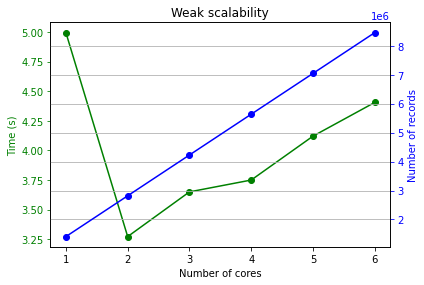

In [7]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(range(1,7), weak_time, 'go-')
ax1.set_xlabel('Number of cores')
ax1.set_ylabel('Time (s)', color='green')
ax1.tick_params('y', colors='g')

ax2 = ax1.twinx()
ax2.plot(range(1,7), all_words, 'bo-')
ax2.set_ylabel('Number of records', color='b')
ax2.tick_params('y', colors='b')

fig.tight_layout()
plt.title('Weak scalability')
plt.grid()
plt.show()

### STRONG scalability

In [18]:
%%capture
strong_time = []
from pyspark.sql import SparkSession

for i in range(1, 7):
    spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.74:7077") \
        .appName("FHV-Scalability")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.cores.max",i)\
        .config("spark.cores.min",i)\
        .config("spark.driver.port",9998)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

    path = 'hdfs://192.168.2.74:9000/user/ubuntu/uber-tlc-foil-response/'
    FHV_file = path+'other-FHV-dataFHV_10_companies_data.parquet'
    FHV_10_companies_data = spark_session.read.parquet(FHV_file)
    df = bigger_dataframe(FHV_10_companies_data, 6)

    start = timeit.default_timer();
 
    words = count_all_words_FHV(df)

    words.collect()[0]
    spark_session.stop()

    stop = timeit.default_timer();
    strong_time.append(round(stop - start, 3))

22/03/18 22:31:33 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:32:05 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:32:30 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:32:54 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:33:17 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.
22/03/18 22:33:40 WARN ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


In [19]:
strong_time

[25.277, 17.876, 16.876, 16.659, 15.552, 15.736]

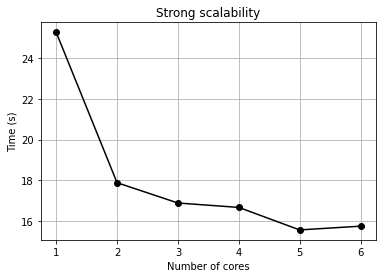

In [20]:
plt.plot(range(1,7), strong_time, 'ko-')
plt.xlabel('Number of cores')
plt.ylabel('Time (s)')
plt.title('Strong scalability')
plt.grid()
plt.show()